In [290]:
#Imports

import lal, lalsimulation, numpy, copy
from pycbc.types import TimeSeries, FrequencySeries, zeros, Array
from pycbc.types import real_same_precision_as, complex_same_precision_as
import pycbc.scheme as _scheme
import inspect
from pycbc.fft import fft
from pycbc import pnutils
from pycbc.waveform import utils as wfutils
from pycbc.waveform import parameters
from pycbc.filter import interpolate_complex_frequency, resample_to_delta_t
import pycbc
import numpy as np
from six.moves import range as xrange

import pycbc.psd
import pycbc.noise
import pycbc.waveform
import pycbc.filter
import numpy as npd
import matplotlib.pyplot as plt

from pycbc.filter import matched_filter
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
import matplotlib.pyplot as pl

from pycbc.psd import interpolate, inverse_spectrum_truncation

%matplotlib inline

from pycbc.waveform import get_td_waveform
import pylab

plt.rcParams['figure.figsize'] = [16, 8]

(-0.01, 0.01)

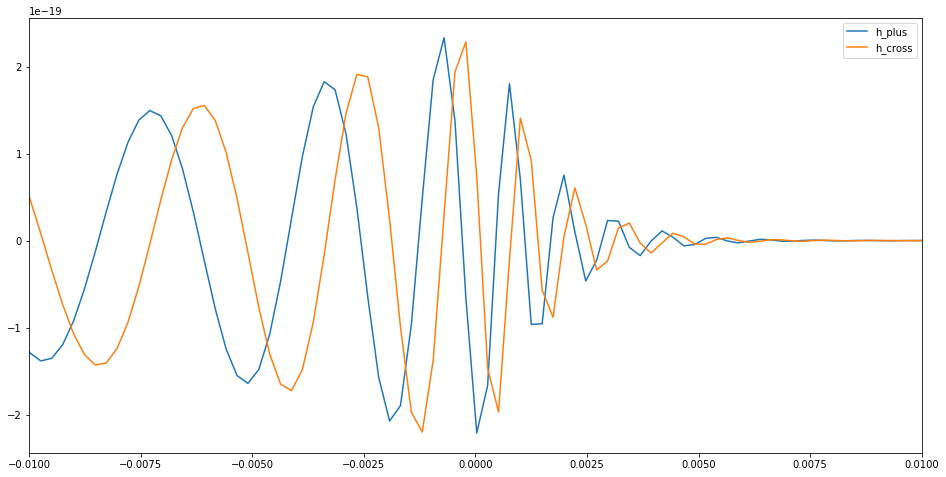

In [291]:
#Pycbc default waveforms

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/4096,
                         f_lower=30)
pylab.plot(hp.sample_times, hp, label="h_plus")
pylab.plot(hc.sample_times, hc, label="h_cross")
plt.legend()
plt.xlim(-0.01,0.01)

In [332]:
#PPE Corrections

def ppe_corrected_waveform(fd_waveform, total_mass, alpha, beta, a, b):
    h_tilde_ppe = fd_waveform.copy()
    for i in range(0, len(h_tilde_ppe.data)):
        freq_i = h_tilde_ppe.sample_frequencies.data[i]
        if(freq_i > 0.0):
            vel_i = pow(np.pi * total_mass * freq_i, 1.0/3.0)
            phase_correction = np.exp(beta * pow(vel_i, b) * 1j)
            amplitude_correction = 1.0 + alpha * pow(vel_i, a)
            h_tilde_ppe.data[i] = h_tilde_ppe.data[i] * amplitude_correction * phase_correction
    return h_tilde_ppe

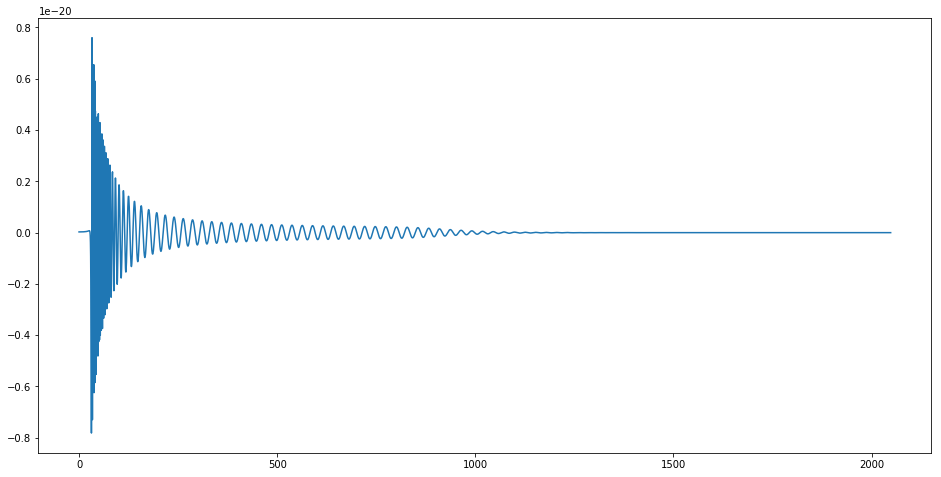

In [333]:
#Compare the difference after FFT'ing and back

hp_tilde = hp.to_frequencyseries()
hp_2 = hp_tilde.to_timeseries()
pylab.plot(hp_tilde.sample_frequencies, hp_tilde)
#pylab.plot(hp_2.sample_times, hp_2-hp, label="h_plus")

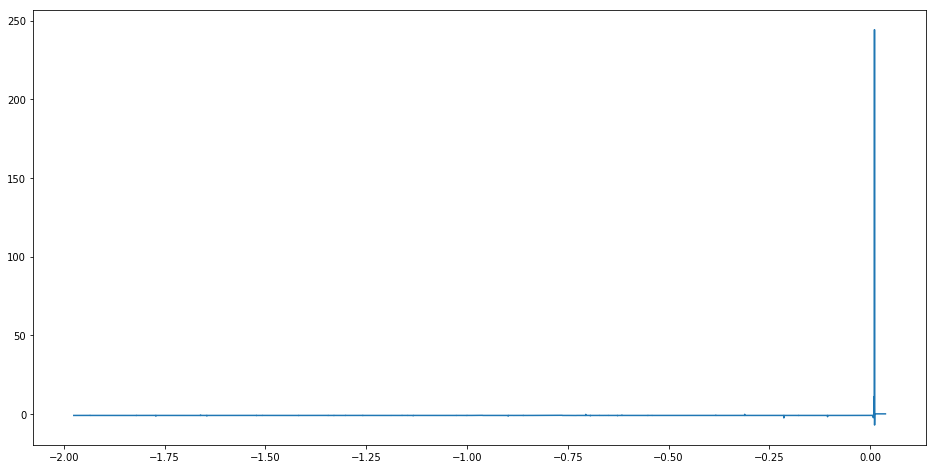

In [330]:
#Unit test that the waveform is flipped by -1 for b = 0, beta = pi

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/4096,
                         f_lower=30)
total_mass = 20
alpha = 0.0
beta = np.pi
a = 0.0
b = 0.0

hp_corrected = ppe_corrected_waveform(hp.to_frequencyseries(), total_mass, alpha, beta, a, b).to_timeseries()

#pylab.plot(hp.sample_times, hp, label="h_plus")
#pylab.plot(hp_corrected.sample_times, hp_corrected, label="h_plus_corrected")
#plt.legend()
plt.plot(hp.sample_times, hp/hp_corrected)
#plt.xlim(0.0,0.01)

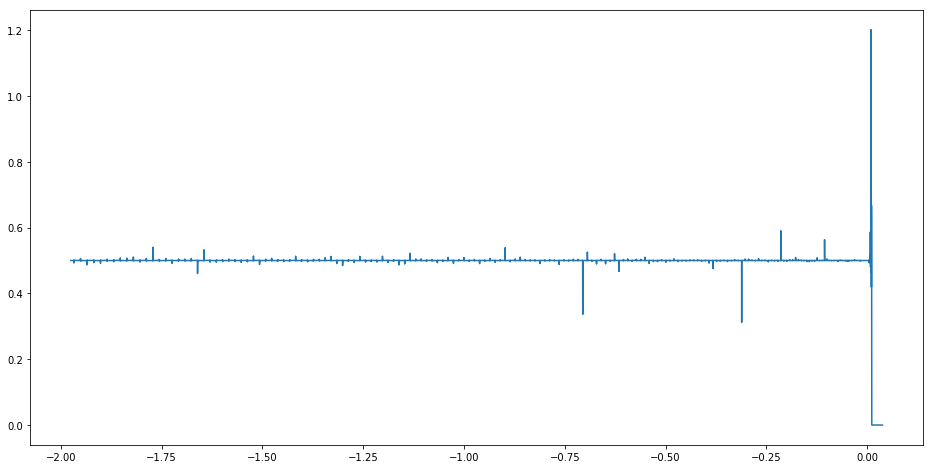

In [331]:
#Unit test that the waveform's amplitude is doubled for a = 0, alpha = 1

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/4096,
                         f_lower=30)
total_mass = 20
alpha = 1.0
beta = 0.0
a = 0.0
b = 0.0

hp_corrected = ppe_corrected_waveform(hp.to_frequencyseries(), total_mass, alpha, beta, a, b).to_timeseries()

#pylab.plot(hp.sample_times, hp, label="h_plus")
#pylab.plot(hp_corrected.sample_times, hp_corrected, label="h_plus_corrected")
#plt.legend()
plt.plot(hp.sample_times, hp/hp_corrected)
#plt.xlim(0.0,0.01)

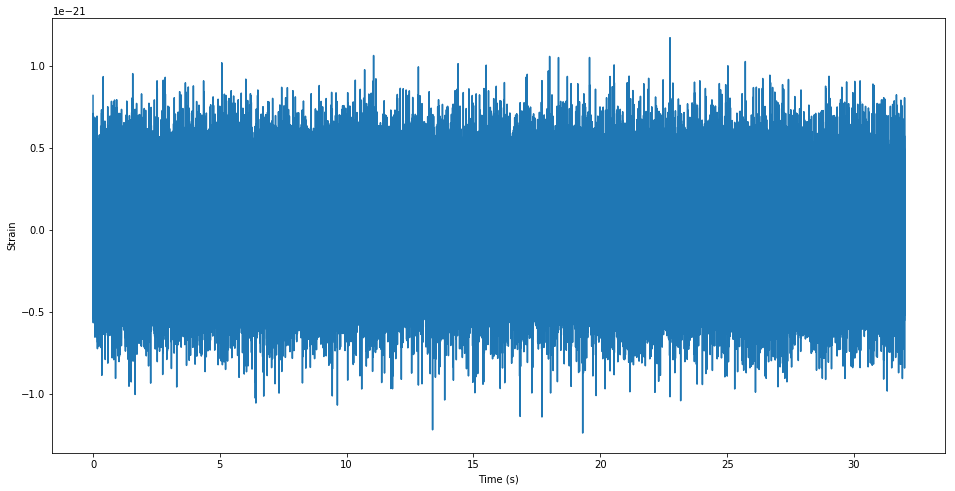

In [231]:
#Pycbc noise example

import pycbc.noise
import pycbc.psd
import pylab

# The color of the noise matches a PSD which you provide
flow = 30.0
delta_f = 1.0 / 32
flen = int(2048 / delta_f) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

# Generate 32 seconds of noise at 4096 Hz
delta_t = 1.0 / 4096
tsamples = int(32 / delta_t)
ts = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=127)

pylab.plot(ts.sample_times, ts)
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.show()

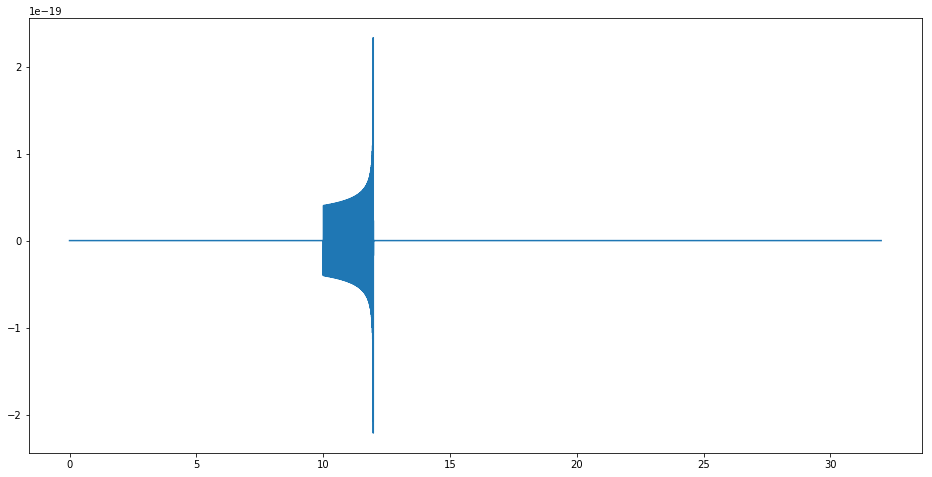

In [232]:
#Create waveform for matched filter test
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/4096,
                         f_lower=30)
hp.resize(len(ts))
template = hp.cyclic_time_shift(10)
template.start_time-=template.start_time
pl.plot(template.sample_times,template)

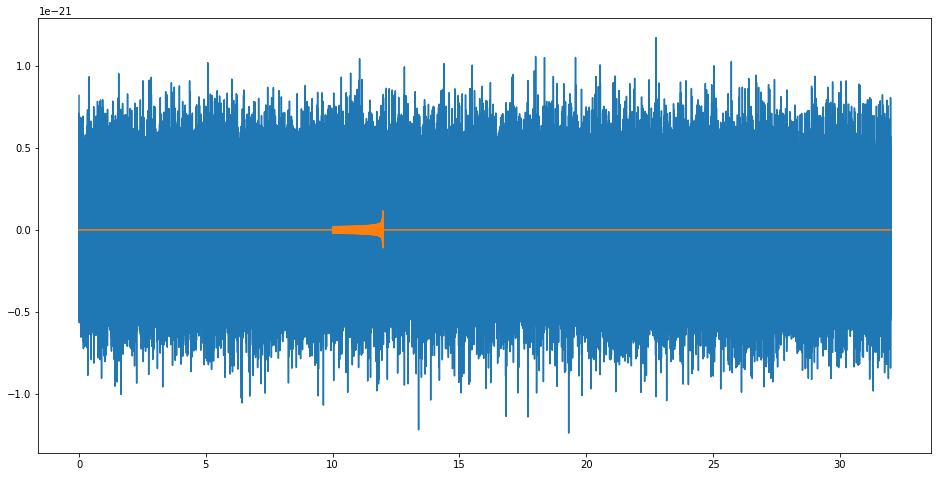

In [234]:
#Plot template and noise

conditioned = 0.0005*template + ts
pl.plot(conditioned.sample_times,conditioned)
pl.plot(template.sample_times, 0.0005*template)

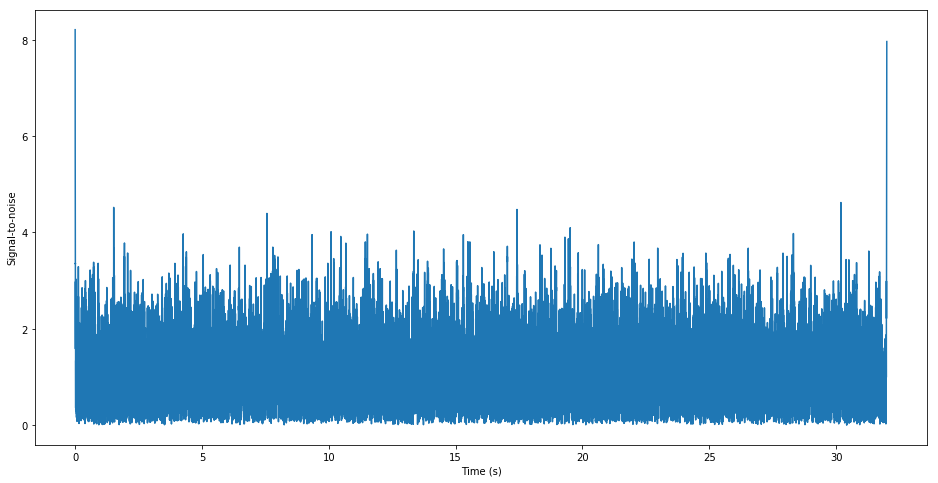

In [235]:
#Plot of SNR

snr = matched_filter(template, conditioned, psd=psd, low_frequency_cutoff=30)
#snr = snr.crop(1, 1)
pl.plot(snr.sample_times, abs(snr))
pl.ylabel('Signal-to-noise')
pl.xlabel('Time (s)')
pl.show()

In [273]:
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("There is a signal at {}s with SNR {}".format(time, abs(snrp)))

There is a signal at 0.0s with SNR 8.20969140527


(-0.04, 0.04)

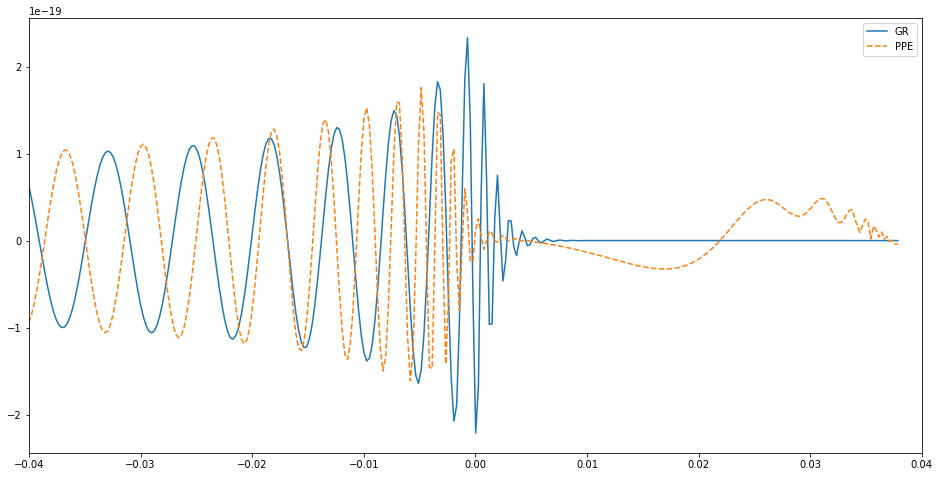

In [354]:
np.seterr(divide='warn', invalid='warn')

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/4096,
                         f_lower=30)
total_mass = 20
alpha = 0.0
beta = 1.4
a = 0.0
b = 1.0

hp_corrected = ppe_corrected_waveform(hp.to_frequencyseries(), total_mass, alpha, beta, a, b).to_timeseries()
plt.plot(hp.sample_times, hp, label = 'GR')
plt.plot(hp_corrected.sample_times, hp_corrected, ls = 'dashed', label = 'PPE')
plt.legend()
plt.xlim(-0.04,0.04)

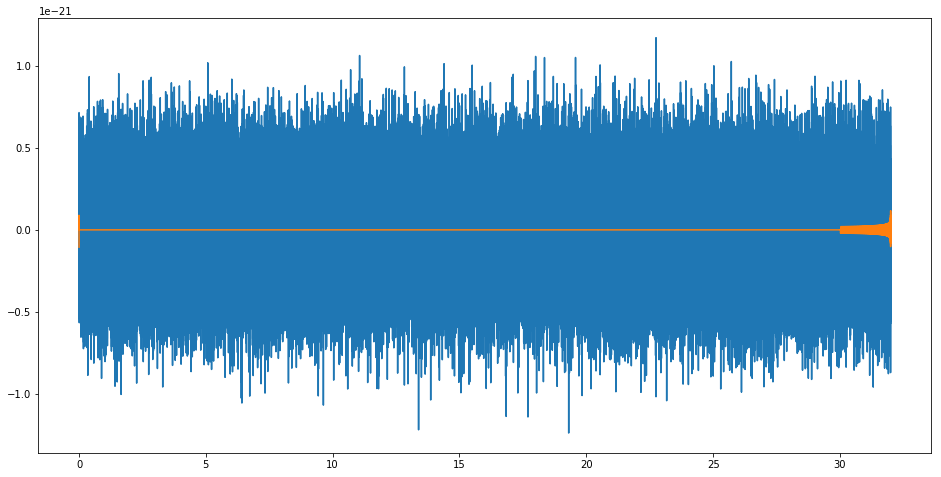

In [279]:
#Plot template and noise
ts = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=127)
hp.resize(len(ts))
template = hp.cyclic_time_shift(hp.start_time)
conditioned = 0.0005*template + ts
pl.plot(conditioned.sample_times,conditioned)
pl.plot(template.sample_times, 0.0005*template)

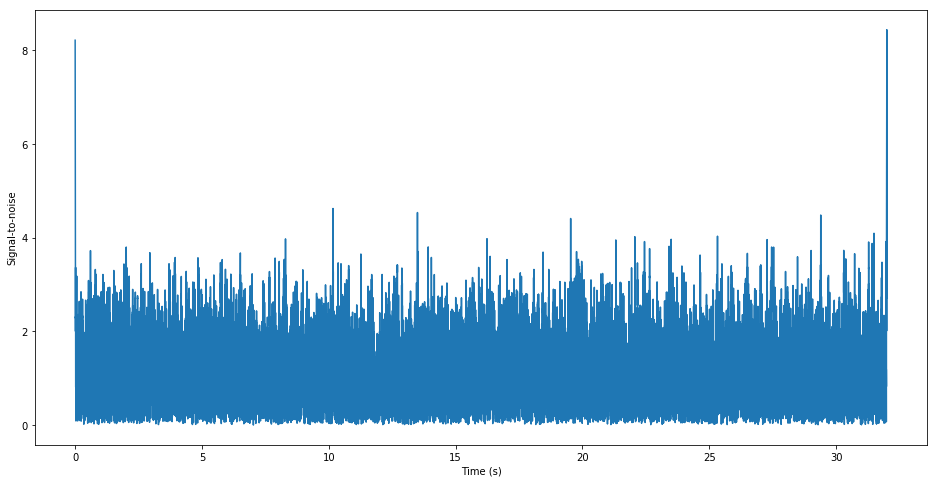

In [280]:
snr = matched_filter(template, conditioned, psd=psd, low_frequency_cutoff=30)
#snr = snr.crop(1, 1)
pl.plot(snr.sample_times, abs(snr))
pl.ylabel('Signal-to-noise')
pl.xlabel('Time (s)')
pl.show()

In [281]:
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("There is a signal at {}s with SNR {}".format(time, abs(snrp)))

There is a signal at 31.9995117188s with SNR 8.43269965789


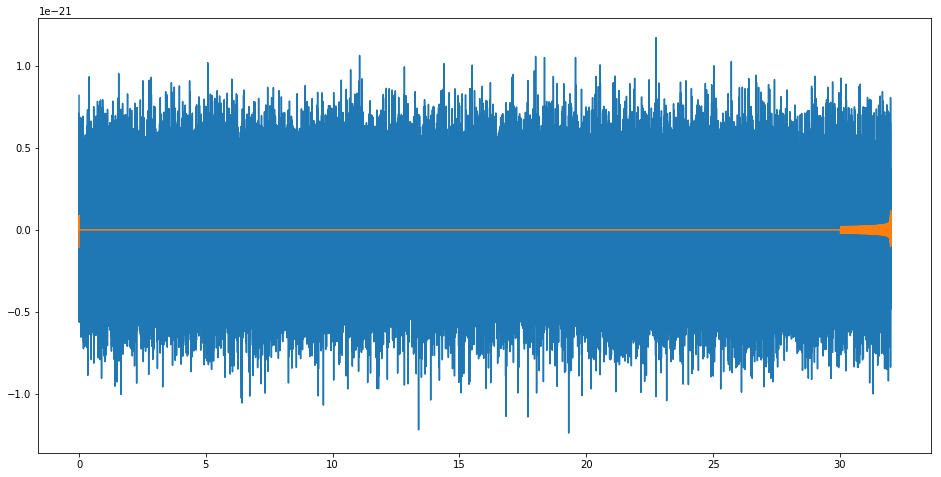

In [287]:
#Plot template and noise
ts = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=127)
hp.resize(len(ts))
hp_corrected.resize(len(ts))
template = hp.cyclic_time_shift(hp.start_time)
template_corrected = hp_corrected.cyclic_time_shift(hp_corrected.start_time)
conditioned = 0.0005*template_corrected + ts
pl.plot(conditioned.sample_times,conditioned)
pl.plot(template.sample_times, 0.0005*template)

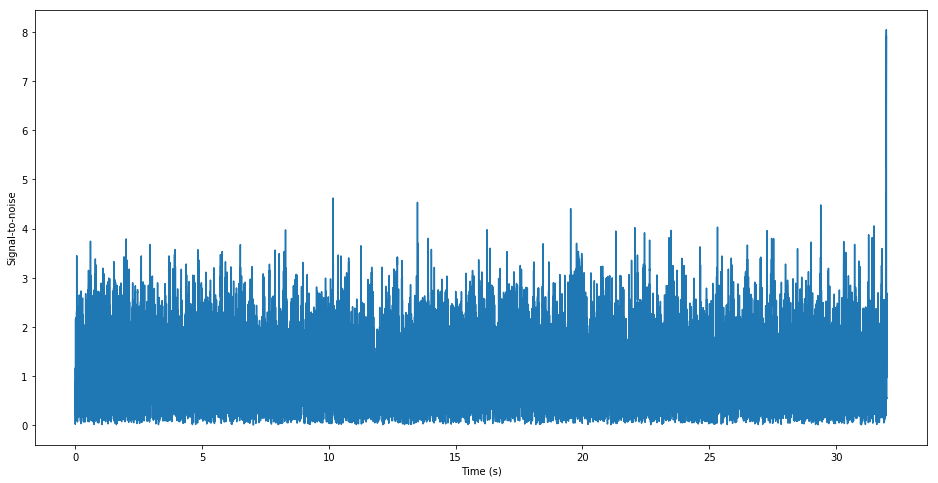

In [288]:
snr = matched_filter(template, conditioned, psd=psd, low_frequency_cutoff=30)
#snr = snr.crop(1, 1)
pl.plot(snr.sample_times, abs(snr))
pl.ylabel('Signal-to-noise')
pl.xlabel('Time (s)')
pl.show()

In [289]:
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("There is a signal at {}s with SNR {}".format(time, abs(snrp)))

There is a signal at 31.9814453125s with SNR 8.0455262423
